In [77]:
import ee

ee.Authenticate()
ee.Initialize(project="uav-route-planning")
import geemap
import numpy as np
import cv2 as cv
from skimage.segmentation import flood_fill
import matplotlib.pyplot as plt
from enum import Enum

#TODO: Try to rewrite as much possible to server side to speed up the code

"""Class detecting edges in images using different bands from Sentinel2"""


class EdgeDetector:

    def __init__(self, points: ee.FeatureCollection, map_center: ee.Geometry.Point, projection: ee.Projection):
        self.__time_periods = [['2017-06-01', '2017-09-01'], ['2018-06-01', '2018-09-01'], ['2019-06-01', '2019-09-01'],
                               ['2020-06-01', '2020-09-01'], ['2021-06-01', '2021-09-01'], ['2022-06-01', '2022-09-01'],
                               ['2023-06-01', '2023-09-01'], ['2024-06-01',
                                                              '2024-09-01']]  # more time periods can provide more
        # accurate data, but also makes calculations slower
        self.__bands = ['B4', 'B3', 'B2']  # bands of satellite imagery that are used for edge detection
        self.__thresholds = [110 if i % 2 == 0 else 120 for i in range(
            6)]  # low and high threshold that is used for each band [low_band1, high_band1, ... ]
        self.__sigmas = [5, 11, 4]  # values of sigma that are used for each of the bands
        self.__distance = 5  # max distance between edges to be connected
        self.__scale = 16  # scale that is used to show results on GEE Map
        self.__projection = projection
        self.__points = points
        self.__map_center = map_center
        self.__cloud_filter_threshold = 5

    # Finding selected band in a selected place
    def __get_band_image(self, band: str, time_period: list) -> ee.Image:
        """ Function that finds particular band for selected image """
        return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate(time_period[0], time_period[1])
                .filterBounds(self.__map_center)
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', self.__cloud_filter_threshold))
                .select(band)
                .mean())

    # Clouds masking is used only for comparison and visualization
    # TODO: change this function
    def __mask_s2_clouds(self, image: ee.Image) -> ee.Image:
        """Masks clouds in a Sentinel-2 image using the QA band.

        Args:
            image (ee.Image): A Sentinel-2 image.

        Returns:
            ee.Image: A cloud-masked Sentinel-2 image.
        """
        qa = image.select('QA60')

        # Bits 10 and 11 are clouds and cirrus, respectively.
        cloud_bit_mask = 1 << 10
        cirrus_bit_mask = 1 << 11

        # Both flags should be set to zero, indicating clear conditions.
        mask = (
            qa.bitwiseAnd(cloud_bit_mask)
            .eq(0)
            .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
        )

        return image.updateMask(mask).divide(10000)

    def __get_RGB_map(self) -> ee.Image:
        """ Function that returns map image for a GEE Map """
        return (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                .filterDate(self.__time_periods[0][0], self.__time_periods[-1][0])
                .filterBounds(self.__map_center)
                # Pre-filter to get less cloudy granules.
                .filter(
            ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', self.__cloud_filter_threshold)
        )
                .map(self.__mask_s2_clouds)
                .mean())

    def __run_canny_for_bands(self, bands_data: list) -> ee.Image:
        """ Function runs Canny edge detection algorithm for every provided band """
        bands_after_canny = []
        for i in range(len(bands_data)):
            low_threshold_detection = (
                ee.Algorithms.CannyEdgeDetector(
                    image=bands_data[i], threshold=self.__thresholds[i], sigma=self.__sigmas[i]
                )
            ).gt(0)
            high_threshold_detection = (
                ee.Algorithms.CannyEdgeDetector(
                    image=bands_data[i], threshold=self.__thresholds[i + 1], sigma=self.__sigmas[i]
                )
            ).gt(0)
            hysteresis_threshold = low_threshold_detection.And(
                high_threshold_detection.focal_max(self.__distance, 'square', 'pixels'))
            bands_after_canny.append(high_threshold_detection.Or(hysteresis_threshold))

        if len(bands_after_canny) > 1:
            aggregated_canny = bands_after_canny[0].Or(bands_after_canny[1])
            for i in range(2, len(bands_after_canny)):
                aggregated_canny = aggregated_canny.Or(bands_after_canny[i])
            return aggregated_canny.select(aggregated_canny.bandNames().get(0).getInfo())
        return bands_after_canny[0]

    def __prepare_result_map(self, results_list: ee.Image) -> geemap.Map:
        """ Prepares result map that is ready to show to user """
        resultMap = geemap.Map()
        center_coords = self.__map_center.coordinates().getInfo()
        resultMap.set_center(center_coords[0], center_coords[1], self.__scale)
        visualization = {
            'min': 0.0,
            'max': 0.3,
            'bands': ['B4', 'B3', 'B2'],
        }
        resultMap.addLayer(self.__get_RGB_map(), visualization, "Source map")
        for i in range(len(results_list)):
            resultMap.addLayer(results_list[i].updateMask(results_list[i]), {"palette": ["ffffff"]},
                               self.__time_periods[i][0] + " - " + self.__time_periods[i][1])
        resultMap.addLayer(self.__points, {'color': 'red'}, 'User input points')
        return resultMap

    def __detect_edges(self) -> list:
        """ Detects edged using Canny detector for selected periods """
        aggregated_canny_results = []
        for time_period in self.__time_periods:
            bands_data = []
            for band in self.__bands:
                bands_data.append(self.__get_band_image(band, time_period))
            aggregated_canny_results.append(self.__run_canny_for_bands(bands_data))
        return aggregated_canny_results

    def detect_and_show_on_map(self) -> geemap.Map:
        """ You can use this function to show results on GEE Map """
        aggregated_canny_results = self.__detect_edges()

        return self.__prepare_result_map(aggregated_canny_results)

    def detect_and_return_merged_bands(self) -> geemap.Map:
        """ Returns GEE Map that containes merged bands for all periods into one image """
        aggregated_canny_results = self.__detect_edges()

        # Merging all the detected edges into one band
        results = ee.ImageCollection(aggregated_canny_results).toBands()
        return results.reduce(ee.Reducer.max())


In [78]:
class Direction(Enum):
    TOP = 0
    BOTTOM = 1
    LEFT = 2
    RIGHT = 3


""" Class that represents map fragments that are stored in AreaDetector class, makes map operations easier """


class MapFragment:
    def __init__(self, center_point: ee.Geometry.Point, projection: ee.Projection, buffer_radius: float,
                 edge_map: geemap.Map, img_resolution: int):
        self.__buffer_radius = buffer_radius
        self.__img_resolution = img_resolution
        self.__projection = ee.Projection(projection)
        self.__center_point = center_point
        self.__scale = 5
        self.__map_representation = self.__move_rectangle_to_numpy(self.__center_point, edge_map)

    def __move_rectangle_to_numpy(self, center_point: ee.Geometry.Point, edge_map: geemap.Map) -> np.array:
        """ Converts map rectangle to NumPy array """
        # TODO: try to use numpy sparse matrix to save space and time while copying data - if everything will happen
        #  on the server side this might be unnecessary
        # select buffer around provided point
        buffer = self.__get_buffer_around_point(center_point)

        # Reproject image to better resolution
        img = edge_map.reproject(self.__projection, None, self.__scale)

        # Extract Rectangle from Image
        band_arrs = img.sampleRectangle(region=buffer, defaultValue=0)

        # Rectangle values to numpy array
        new_image = None
        for band in img.bandNames().getInfo():
            current_band = band_arrs.get(band)
            img = np.array(current_band.getInfo())
            img = img.astype(float)
            # Stacking each band
            if new_image is None:
                new_image = img
            else:
                new_image = np.dstack([new_image, img])
        return new_image

    def contains_point(self, point: ee.Geometry.Point) -> bool:
        """ Function that checks whether a point is inside the map fragment """
        if self.__get_buffer_around_point(self.__center_point).bounds(proj=self.__projection).intersects(point).getInfo():
            return True
        return False

    def __get_buffer_around_point(self, point: ee.Geometry.Point) -> ee.Geometry:
        """ Returns buffer around point """
        return point.buffer(self.__buffer_radius, proj=self.__projection)

    def find_near_map_fragment_center(self, x_direction: int, y_direction: int) -> ee.Geometry.Point:
        """ Returns center point of map fragment next to the current one """
        x, y = self.get_center_point_coordinates_reprojected()
        return ee.Geometry.Point(
            [x + x_direction * self.__buffer_radius * 2, y - y_direction * self.__buffer_radius * 2],
            proj=self.__projection)

    def get_center_point_coordinates(self) -> tuple[float, float]:
        """ Returns center point coordinates of map fragment in degrees """
        return self.__center_point.coordinates().getInfo()

    def get_center_point_coordinates_reprojected(self) -> tuple[float, float]:
        """ Returns center point coordinates of map fragment in meters """
        return self.__center_point.transform(self.__projection).coordinates().getInfo()

    def run_flood_fill(self, x: int, y: int):
        """ Runs flood fill on map fragment - detected areas have value of 0.5 to differentiate them from the edges """
        self.__map_representation[:] = flood_fill(self.__map_representation, (y, x), 0.5)
        
    def apply_two_thresholds(self, threshold1: float = 0.0, threshold2: float = 1.0):
        """ Applies thresholding with two thresholds on map fragment to extract detected areas from image """
        for y in range(len(self.__map_representation)):
            for x in range(len(self.__map_representation[y])):
                if threshold1 < self.__map_representation[y][x] < threshold2:
                    self.__map_representation[y][x] = 255
                else:
                    self.__map_representation[y][x] = 0
        self.__map_representation = self.__map_representation.astype(np.uint8)
        
    def apply_one_threshold(self, threshold: float = 0):
        for y in range(len(self.__map_representation)):
            for x in range(len(self.__map_representation[y])):
                if self.__map_representation[y][x] > threshold:
                    self.__map_representation[y][x] = 255
                else:
                    self.__map_representation[y][x] = 0
        self.__map_representation = self.__map_representation.astype(np.uint8)
                
    def apply_morphology_close(self, kernel_size: int = 5):
        """ Applies morphological close with selected kernel size to reduce discontinuity in image, mask size needs to be odd number """
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        self.__map_representation = cv.morphologyEx(self.__map_representation, cv.MORPH_CLOSE, kernel)
        
    def get_boundary_points(self) -> list[int]:
        """ Returns points of the detected areas boundaries """
        contours, hierarchy = cv.findContours(self.__map_representation, cv.RETR_CCOMP, cv.CHAIN_APPROX_TC89_KCOS)
        # tymczasowo -  rysowanie rezultatu
        image_contour = cv.cvtColor(self.__map_representation, cv.COLOR_GRAY2BGR)  # Image for contours
        image_points = cv.cvtColor(self.__map_representation, cv.COLOR_GRAY2BGR)   # Image for points
        
        # Draw the contours on the contour image
        for contour in contours:
            cv.drawContours(image_contour, [contour], -1, (255, 0, 255), 2) 
        
        # Draw the points on the points image
        for contour in contours:
            for point in contour:
                cv.circle(image_points, tuple(point[0]), 1, (128, 0, 128), -1) 
                
        image_contour_rgb = cv.cvtColor(image_contour, cv.COLOR_BGR2RGB)
        image_points_rgb = cv.cvtColor(image_points, cv.COLOR_BGR2RGB)
        
        # Plot side by side
        plt.figure(figsize=(12, 6))
        
        # Contours
        plt.subplot(1, 2, 1)
        plt.imshow(image_contour_rgb)
        plt.title("Contours")
        plt.axis('off')
        
        # Points
        plt.subplot(1, 2, 2)
        plt.imshow(image_points_rgb)
        plt.title("Contour Points")
        plt.axis('off')
        plt.savefig('Contour.jpg', dpi=500, bbox_inches='tight')
        plt.close()
        
        plt.show()
        
        return 


    def check_bounds(self) -> tuple[
        list[tuple[int, int]], list[tuple[int, int]], list[tuple[int, int]], list[tuple[int, int]]]:
        """ Checks if any detected area is at the bounds of the map fragment and returns points for flood fill each adjacent map fragments """
        points_for_flood_fill = ([], [], [],
                                 [])  # tuple that contains list of the points that will be used for flood fill to the adjacent map fragments

        for i in range(len(self.__map_representation)):
            self.__check_bound(i, 0, points_for_flood_fill[0], Direction.TOP)
            self.__check_bound(i, -1, points_for_flood_fill[1], Direction.BOTTOM)
            self.__check_bound(0, i, points_for_flood_fill[2], Direction.LEFT)
            self.__check_bound(-1, i, points_for_flood_fill[3], Direction.RIGHT)

        return points_for_flood_fill

    def __check_bound(self, x: int, y: int, points_for_flood_fill: list[tuple[int, int]],
                      direction: Direction) -> bool:
        """ Checks if an edge point is considered as a searched area and adds it to the list if that is true, returns boolean that informs if previous area was closed, possible values for direction is vertical and horizontal """
        if self.__map_representation[y][x] == 0.5:
            if direction == Direction.TOP:
                points_for_flood_fill.append((x, 255))
            elif direction == Direction.BOTTOM:
                points_for_flood_fill.append((x, 0))
            elif direction == Direction.LEFT:
                points_for_flood_fill.append((255, y))
            elif direction == Direction.RIGHT:
                points_for_flood_fill.append((0, y))

    def convert_point_to_img_coordinates(self, point: ee.Geometry.Point) -> list[int]:
        """ Function that returns point ready to plot using matplotlib """
        buffer = self.__center_point.buffer(self.__buffer_radius,
                                            proj=self.__projection)  # selecting buffer around point

        buffer_origin = buffer.bounds(proj=self.__projection).coordinates().getInfo()[0][3]
        buffer_origin = ee.Geometry.Point(buffer_origin, proj=self.__projection)
        base = buffer_origin.coordinates().getInfo()  # base -> [y, x]
        point_coordinates = point.coordinates().getInfo()  # coordinates of point -> [y, x]

        y = int(round((base[1] - point_coordinates[1]) / self.__img_resolution))
        x = int(round((point_coordinates[0] - base[0]) / self.__img_resolution))

        return [x, y]
    
    def convert_point_to_map_coordinates(self, x: int, y: int) -> tuple[float, float]:
        """ Converts point from map representation into the point coordinates that correspond to the real coordinates that are used by the map """
        # TODO: musisz się dowiedzieć jak konkretnie ma to być wykorzystane wyświetlane - w jakim formacie będą docelowe współrzędne do wyświetlania oraz do planowania trasy
        return ()
    
    def get_image(self) -> np.array:
        """ Returns representation of map fragment as a np.array """
        return self.__map_representation

    def get_pixel_value(self, x: int, y: int) -> float:
        return self.__map_representation[y][x]

In [79]:
""" Class that is responsible of detecting areas in images that contain results of Canny Edge Detection """


class AreaDetector:

    def __init__(self, edge_map: geemap.Map, map_center: ee.Geometry.Point, projection: ee.Projection):
        self.__edge_map = edge_map
        self.__projection = projection
        self.__map_center = map_center  # nie wiem czy to jest jeszcze potrzebne, na razie zostaje
        self.__detected_areas_map = [[]]  # MapFragments objects stored in array
        self.__patch_size = 256
        self.__img_resolution = 5  # to chyba może być przerzucone w całości do klasy map fragment :)
        self.__buffer_radius = (self.__patch_size / 2) * self.__img_resolution
        self.__load_map_fragment(self.__map_center, 0, 0)

    def __load_map_fragment(self, center_point: ee.Geometry.Point, x_pos_to_insert: int, y_pos_to_insert: int):
        """ Initiates a map around center point of image """
        new_map_fragment = MapFragment(center_point, self.__projection, self.__buffer_radius, self.__edge_map,
                                       self.__img_resolution)
        self.__detected_areas_map[y_pos_to_insert].insert(x_pos_to_insert, new_map_fragment)


    def __search_row_for_the_map_fragment(self, map_fragment_center_coordinates: tuple[float, float],
                                          point_coordinates: tuple[float, float],
                                          row_num: int, point: ee.Geometry.Point) -> tuple[int, int]:
        """ Searches for map fragment in row and returns coordinates of map fragment as [row_num, col_num] """
        direction_x = 0
        if (point_coordinates[0] - map_fragment_center_coordinates[0]) <= -self.__buffer_radius:
            direction_x = -1
        elif (point_coordinates[0] - map_fragment_center_coordinates[0]) >= self.__buffer_radius:
            direction_x = 1

        if direction_x >= 0:
            for col_num in range(len(self.__detected_areas_map[row_num])):
                if self.__detected_areas_map[row_num][col_num].contains_point(point):
                    return row_num, col_num
            # if there is no buffer that contains searched point, we have to add next one
            current_map_fragment = self.__detected_areas_map[row_num][-1]
            self.__load_map_fragment(current_map_fragment.find_near_map_fragment_center(direction_x, 0),
                                     len(self.__detected_areas_map[row_num]), row_num)
            return row_num, len(self.__detected_areas_map[row_num]) - 1

        else:
            while True:
                current_map_fragment = self.__detected_areas_map[row_num][0]
                self.__load_map_fragment(current_map_fragment.find_near_map_fragment_center(-1, 0), 0, row_num)
                if self.__detected_areas_map[row_num][0].contains_point(point):
                    return row_num, 0

    def __search_for_the_map_fragment(self, row_num: int, point: ee.Geometry.Point) -> tuple[int, int]:
        # UWAGA - JEŻELI PUNKTY BĘDĄ W BARDZO DUŻYCH ODLEGŁOŚCIACH OD SIEBIE - WIĘCEJ NIŻ JEDEN SEGMENT TO SIĘ WYWALI BO NIE ZNAJDZIE FRAGMENTU I NIE BĘDZIE WIEDZIAŁ JAK DODAĆ
        """ Searches self.__detected_areas_map for row where point is located and returns map fragment coordinates as [row_num, col_num] """
        if row_num < 0:
            self.__detected_areas_map.insert(0, [])  # new row at the top is added
            current_map_fragment = self.__detected_areas_map[1][0]  # we start looking from the lower row
            self.__load_map_fragment(current_map_fragment.find_near_map_fragment_center(0, -1), 0, 0)
            return self.__search_for_the_map_fragment(row_num + 1, point)

        if row_num >= len(self.__detected_areas_map):
            self.__detected_areas_map.append([])
            current_map_fragment = self.__detected_areas_map[-1][0]  # we start from the last row
            self.__load_map_fragment(current_map_fragment.find_near_map_fragment_center(0, 1), 0,
                                     len(self.__detected_areas_map) - 1)
            return self.__search_for_the_map_fragment(row_num, point)

        map_fragment_center = self.__detected_areas_map[row_num][0].get_center_point_coordinates_reprojected()
        direction_y = 0
        point_coordinates = point.coordinates().getInfo()

        if (map_fragment_center[1] - point_coordinates[1]) <= -self.__buffer_radius:
            direction_y = -1
        elif (map_fragment_center[1] - point_coordinates[1]) >= self.__buffer_radius:  # nie wiem czy nie trzeba tego podzielić przez resolution?? - ale chyba nie
            direction_y = 1

        if direction_y == -1:
            if row_num - 1 < 0:
                current_map_fragment = self.__detected_areas_map[0][0]
                self.__detected_areas_map.insert(0, [])  # new row at the top is added
                self.__load_map_fragment(current_map_fragment.find_near_map_fragment_center(0, -1), 0,
                                         row_num)
                return self.__search_for_the_map_fragment(row_num + 1, point)
            else:
                return self.__search_for_the_map_fragment(row_num - 1, point)

        elif direction_y == 1:
            if row_num + 1 >= len(self.__detected_areas_map):
                current_map_fragment = self.__detected_areas_map[row_num][0]
                self.__detected_areas_map.append([])
                self.__load_map_fragment(current_map_fragment.find_near_map_fragment_center(0, direction_y), 0,
                                         row_num + 1)
            # we are moving searching to the next row
            return self.__search_for_the_map_fragment(row_num + 1, point)

        # if current row is correct, we start searching inside it
        return self.__search_row_for_the_map_fragment(map_fragment_center, point_coordinates, row_num, point)

    def detect_areas(self, coordinates_list: list[tuple[float, float]]) -> None:
        """ Detects area that contains provided point """
        # TODO: try to paralelize detecting areas

        for point_coordinates in coordinates_list:
            projected_point = ee.Geometry.Point(point_coordinates, proj=self.__projection)

            # searching for corresponding map fragment for the point
            row_num, col_num = self.__search_for_the_map_fragment(0, projected_point)

            found_map_fragment = self.__detected_areas_map[row_num][col_num]
            x, y = found_map_fragment.convert_point_to_img_coordinates(projected_point)
            found_map_fragment.run_flood_fill(x, y)

            self.detect_in_adjacent_map_fragments(found_map_fragment, row_num)

    def detect_in_adjacent_map_fragments(self, found_map_fragment: MapFragment, row_num: int) -> None:
        """ Runs area detection in adjacent map fragments if this is necessary - when area detected previously is beyond current map fragment """
        points_to_check = found_map_fragment.check_bounds()
        for direction in Direction:
            if len(points_to_check[direction.value]) == 0:
                # we don't have to check map fragment in this direction as there aren't any areas detected in this direction
                continue

            new_row_num, new_col_num = (0, 0)
            if direction == Direction.TOP:
                center_point = found_map_fragment.find_near_map_fragment_center(0, -1)
                new_row_num, new_col_num = self.__search_for_the_map_fragment(row_num - 1, center_point)
            elif direction == Direction.BOTTOM:
                center_point = found_map_fragment.find_near_map_fragment_center(0, 1)
                new_row_num, new_col_num = self.__search_for_the_map_fragment(row_num + 1, center_point)
            elif direction == Direction.LEFT:
                center_point = found_map_fragment.find_near_map_fragment_center(-1, 0)
                new_row_num, new_col_num = self.__search_for_the_map_fragment(row_num, center_point)
            else:
                center_point = found_map_fragment.find_near_map_fragment_center(1, 0)
                new_row_num, new_col_num = self.__search_for_the_map_fragment(row_num, center_point)

            was_flood_fill_run = False
            for coordinates in points_to_check[direction.value]:
                # here we run flood fill for all fragments
                adjacent_fragment = self.__detected_areas_map[new_row_num][new_col_num]
                if adjacent_fragment.get_pixel_value(coordinates[0], coordinates[1]) == 0:
                    adjacent_fragment.run_flood_fill(coordinates[0], coordinates[1])
                    was_flood_fill_run = True

            if was_flood_fill_run:
                # we check if we have to detect anything in adjacent map fragments
                self.detect_in_adjacent_map_fragments(adjacent_fragment, new_row_num)
                
    def extract_points(self) -> list[tuple[float, float]]:
        """ Returns outline points from detected area """
        # tutaj trzeba tak
        # najpierw progowanie żeby wyciągnąć tylko wykryte tereny
        # potem morfologia - zamknięcie
        # potem znowu progowanie - w ten sposób tereny powinny być lepiej połączone - pewnie będzie trzeba dobrać odpowiednie parametry do rozmycia, zobaczymy jak to będzie wyglądać
        # następnie trzeba zaimplementować wyciąganie konturu z każdego fragmentu mapy i usuwanie punktów, które należą do obrysu fragmentu mapy
        # konwersja punktów na obrazku na punkty na mapie
        # dodanie wszystkich punktów do jednej tablicy, która będzie mogła zwrócić wynik do frontendu
        # fajrant :)
        # dla filtrów liniowych jest też wersja, która działa na CUDA - nie wiem czy jest sens ją implementować
        counter = 1
        for row in range(len(self.__detected_areas_map)):
            for column in range(len(self.__detected_areas_map[row])):
                
                self.__detected_areas_map[row][column].apply_two_thresholds()
                
                plt.figure()
                plt.imshow(self.__detected_areas_map[row][column].get_image(), cmap='gray', vmin=0, vmax=1)
                plt.axis("off")
                plt.savefig('Thresholding.jpg', dpi=500, bbox_inches='tight')
                plt.close()
                
                self.__detected_areas_map[row][column].apply_morphology_close(7)
                
                plt.figure()
                plt.imshow(self.__detected_areas_map[row][column].get_image(), cmap='gray', vmin=0, vmax=1)
                plt.axis("off")
                plt.savefig('Morhphology.jpg', dpi=500, bbox_inches='tight')
                plt.close()
                
                self.__detected_areas_map[row][column].apply_one_threshold()
                self.__detected_areas_map[row][column].get_boundary_points()
        return []
                
                

    def plot_result(self, points_coordinates: list[tuple[int, int]]) -> None:
        """ Plots result of area detection """
        # to też trzeba zmienić żeby plotowało więcej fragmentów niż tylko jeden
        counter = 1
        for row_index in range(len(self.__detected_areas_map)):
            for map_fragment in self.__detected_areas_map[row_index]:
                plt.figure()
                plt.imshow(map_fragment.get_image(), cmap='gray', vmin=0, vmax=1)
                for coordinates in points_coordinates:
                    prepared_coordinates = map_fragment.convert_point_to_img_coordinates(
                        ee.Geometry.Point(coordinates[0], coordinates[1]))
                    plt.plot(prepared_coordinates[0], prepared_coordinates[1], 'ro', markersize=5)
                plt.axis("off")
                plt.savefig('Canny' + str(counter) + '.jpg', dpi=500, bbox_inches='tight')
                counter += 1

    def get_map_fragment(self, row_num: int, col_num: int):
        """ Returns map fragment at the provided position, function created for testing purposes """
        return self.__detected_areas_map[row_num][col_num]

In [80]:
""" Class that controls detection of areas and returns results of it as a polygon points """


class AreaDetectionController:

    def __init__(self, points_list: list[ee.Geometry.Point]):
        self.__area_detector = None
        self.__projection = ee.Projection('EPSG:3035')  # projection that is accurate only to Europe!
        self.__points = ee.FeatureCollection([ee.Feature(point.transform(self.__projection)) for point in
                                              points_list])  # point is created as EPSG:4326 projection by default
        self.__map_center = self.__points.geometry().centroid()
        self.__edge_detector = EdgeDetector(self.__points, self.__map_center, self.__projection)

    def run_area_detection(self):
        """ Detects area for all points that were provided to class """
        detected_edges_map = self.__edge_detector.detect_and_return_merged_bands()
        self.__area_detector = AreaDetector(detected_edges_map, self.__map_center, self.__projection)

        coordinates_list = self.__points.toList(self.__points.size()).map(
            lambda f: (ee.Feature(f).geometry().coordinates())
        ).getInfo()  # creating list of coordinates to use for function on the client side

        coordinates_list = [tuple(coordinates) for coordinates in coordinates_list]

        self.__area_detector.detect_areas(coordinates_list)
        
        self.__area_detector.extract_points()
        
        #self.__area_detector.plot_result(coordinates_list)  # delete this later

In [29]:
""" Test of edge detection and passing two points """

longitude = 53.32416 # y
latitude = 18.44861 # x
point = ee.Geometry.Point([latitude, longitude])
point2 = ee.Geometry.Point([18.445007, 53.325876])
points_list = [point, point2]
projection = ee.Projection("EPSG:3035")
points =  ee.FeatureCollection([ee.Feature(point.transform(projection)) for point in points_list])
map_center = points.geometry().centroid()

detector = EdgeDetector(points, map_center, projection)
map = detector.detect_and_show_on_map()
map

Map(center=[53.325018089014385, 18.446808536225866], controls=(WidgetControl(options=['position', 'transparent…

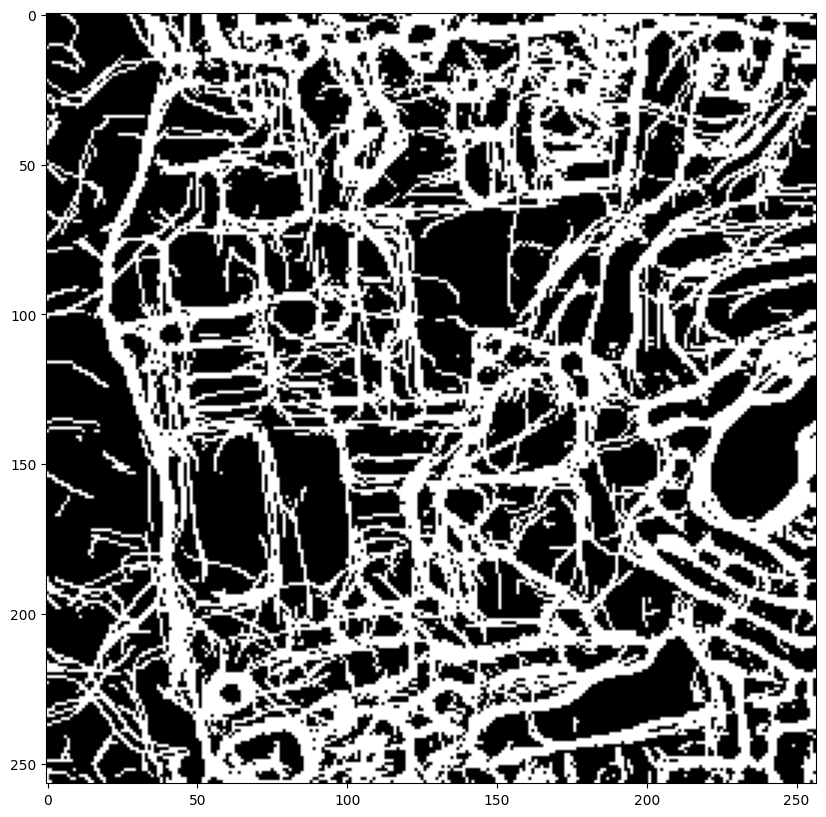

In [6]:
""" Test of numpy visualization """

longitude = 54.6014 # y
latitude = 18.090 # x
point = ee.Geometry.Point([latitude, longitude])

points_list = [point]
projection = ee.Projection("EPSG:3035")
points =  ee.FeatureCollection([ee.Feature(point.transform(projection)) for point in points_list])
map_center = points.geometry().centroid()

edgeDetector = EdgeDetector(points, map_center, projection)
map = edgeDetector.detect_and_return_merged_bands()

areaDetector = AreaDetector(map, map_center, projection)
img_array = areaDetector.get_map_fragment(0, 0)._MapFragment__move_rectangle_to_numpy(ee.Geometry.Point(ee.Feature(points.first()).geometry().coordinates(), 'EPSG:3035'), map)

fig, axs = plt.subplots(figsize=(10, 10))

# Plot Image in an RGB Composite
axs.imshow(img_array, cmap='gray', vmin=0, vmax=1)
plt.show()

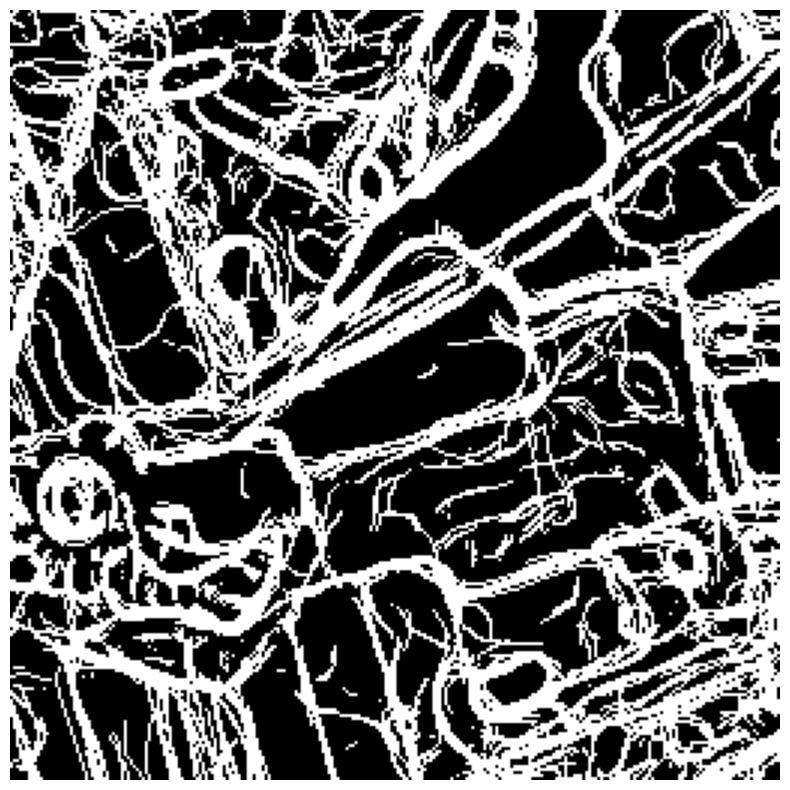

In [31]:
longitude = 53.325556
latitude = 18.443333

point = ee.Geometry.Point([latitude, longitude])

points_list = [point]
projection = ee.Projection("EPSG:3035")
points =  ee.FeatureCollection([ee.Feature(point.transform(projection)) for point in points_list])
map_center = points.geometry().centroid()

edgeDetector = EdgeDetector(points, map_center, projection)
map = edgeDetector.detect_and_return_merged_bands()

areaDetector = AreaDetector(map, map_center, projection)
img_array = areaDetector.get_map_fragment(0, 0)._MapFragment__move_rectangle_to_numpy(ee.Geometry.Point(ee.Feature(points.first()).geometry().coordinates(), 'EPSG:3035'), map)

fig, axs = plt.subplots(figsize=(10, 10))

# Plot Image in an RGB Composite
axs.imshow(img_array, cmap='gray', vmin=0, vmax=1)
# plt.show()

plt.axis("off")
plt.savefig('Canny.jpg', dpi=1000, bbox_inches='tight')

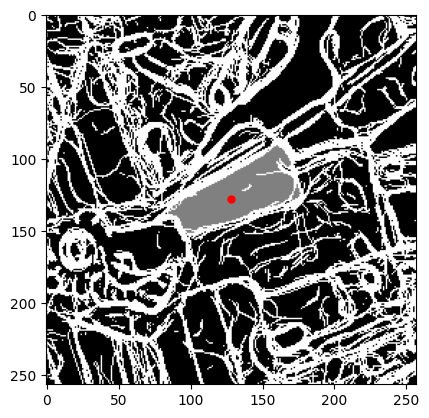

In [8]:
""" Single area detection """

longitude = 53.325556
latitude = 18.443333
point = ee.Geometry.Point([latitude, longitude])
points_list = [point]

areaDetectionController = AreaDetectionController(points_list)
areaDetectionController.run_area_detection()

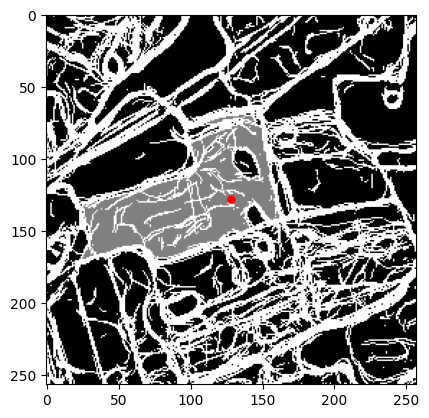

In [9]:
""" Single area detection """

longitude = 53.324167
latitude = 18.448611

point = ee.Geometry.Point([latitude, longitude])
points_list = [point]

areaDetectionController = AreaDetectionController(points_list)
areaDetectionController.run_area_detection()

In [81]:
""" Trying detection using two points """

longitude = 53.324167
latitude = 18.448611
point = ee.Geometry.Point([latitude, longitude])

longitude2 = 53.325556
latitude2 = 18.443333
point2 = ee.Geometry.Point([latitude2, longitude2])

points_list = [point, point2]

areaDetectionController = AreaDetectionController(points_list)
areaDetectionController.run_area_detection()

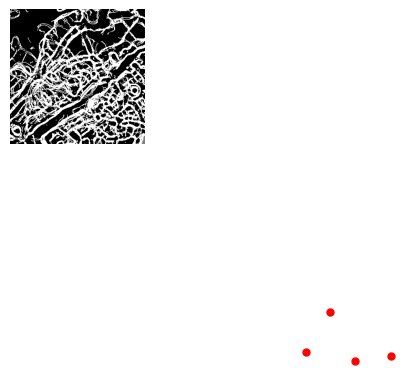

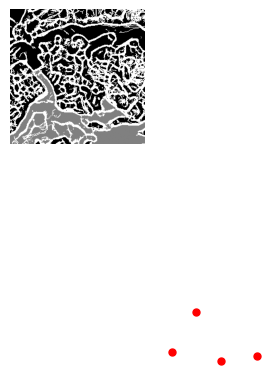

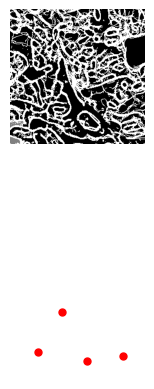

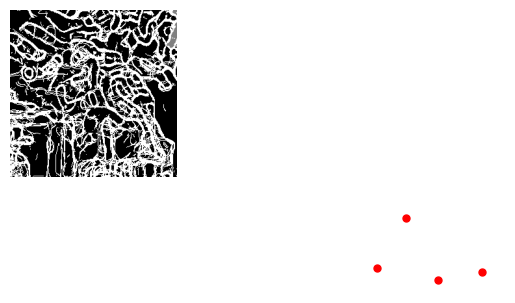

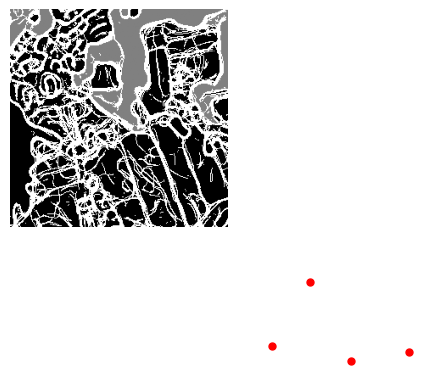

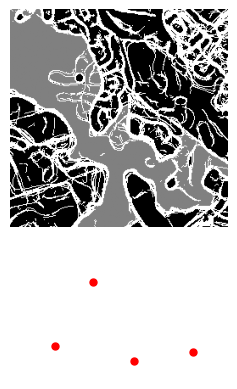

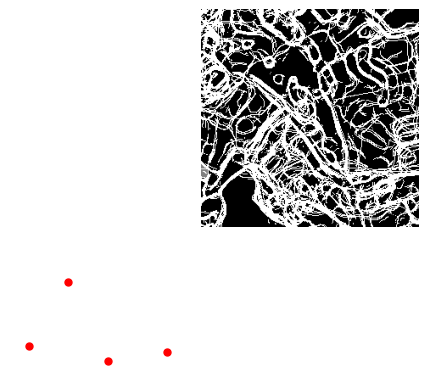

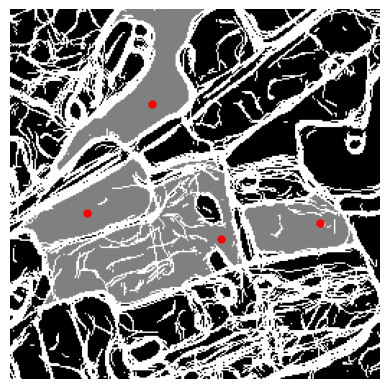

In [76]:
""" Detection using multiple points """

longitude = 53.324389
latitude = 18.455298
point = ee.Geometry.Point([latitude, longitude])

longitude2 = 53.325556
latitude2 = 18.443333
point2 = ee.Geometry.Point([latitude2, longitude2])

longitude3 = 53.328713
latitude3 = 18.447336
point3 = ee.Geometry.Point([latitude3, longitude3])

longitude4 = 53.324253
latitude4 = 18.450105
point4 = ee.Geometry.Point([latitude4, longitude4])

points_list = [point, point2, point3, point4]

areaDetectionController = AreaDetectionController(points_list)
areaDetectionController.run_area_detection()